# DCGAN in Keras
---
Student: Pablo Javier de Paz Carbajo <br>

More info about me: https://www.linkedin.com/in/pablodepaz/

Python Notebook belonging to the Final Year Project **"A review on Generative Adversarial Networks for unsupervised Machine Learning"** done in _Universidad Carlos III de Madrid_ and presented in June 2019.

---

First of all, import **Keras**, an open-source neural network library for Python, and _matplotlib_ for plotting the digits. In addition, import some Keras’ components that will be used later on and _numpy_.

In [1]:
import keras
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Dropout, Reshape, Flatten
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import cifar10
from keras.optimizers import Adam

from keras import initializers
from tqdm import tqdm

import numpy as np

Using TensorFlow backend.


Next, the random noise vector will always have the same dimension:

In [0]:
np.random.seed(1000)

#Dimension of a random noise vector.
random_dim = 100

I shall use CIFAR-10 dataset which contains images (32x32x3) of 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. <br>

It has a **training set of 50,000 examples** and a **test set of 10,000 examples**.

This dataset is available with Keras and can be imported as <pre>cifar10.load_data()</pre>

After, I create a function to import the database and normalize the inputs.

Here, **should you choose which class to import from CIFAR-10**.

In [0]:
def load_cifar10_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    #Select Class (in this case: automobile chosen)
    x_train = x_train[y_train[:,0]==1]
    print ("Training shape: {}".format(x_train.shape))

    #Normalize    
    x_train = (x_train - 127.5) / 127.5
        
    return (x_train, y_train, x_test, y_test)

------

For the **discriminator** and **generator** neural networks, both an optimizer and an activation function are needed. 
- For the first one, I am using ADAM’s optimizer. It achieves good results very quickly by computing gradient descent. 
- Regarding the activation function of G, I use the Hyperbolic Tangent because it ranges (-1,1) unlike the Sigmoid function which ranges (0,1). For D, a special type of ramp function called _Leaky ReLU_. This function is mainly defined for the positive part of its input, x, and allows a small, positive gradient when the unit is not active, x<0.

![](https://i.ibb.co/v1C1jpV/Captura-de-pantalla-2019-05-31-a-las-19-18-00.png "Formula")

![](https://i.ibb.co/khjtkc9/Captura-de-pantalla-2019-05-31-a-las-19-18-09.png "Leaky ReLU")

I use the ```Adam optimizer``` in both networks. 

In [4]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


-----
#Discriminator and Generator

Let's create the **generator** and **discriminator networks**. 

###Generator

We set the kernel initializer as `RandomNormal` which generates tensors with a normal distribution. <br>
We pass the `stddev` parameter which is a python scalar and represents the standard deviation of the random values to generate. <br>
We also add dropout layers to fight overfitting.

In [5]:
generator = Sequential()

#Input layer
generator.add(Dense(128*16*16, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(BatchNormalization(momentum=0.9))
generator.add(LeakyReLU(0.1))
generator.add(Reshape((16, 16, 128)))

#Hidden layer
generator.add(Conv2D(128, kernel_size=5, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.9))   
generator.add(LeakyReLU(alpha=0.1))

#Hidden layer
generator.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(LeakyReLU(alpha=0.1))

#Hidden layer
generator.add(Conv2D(128, kernel_size=5, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(LeakyReLU(alpha=0.1))

#Hidden layer
generator.add(Conv2D(128, kernel_size=5, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(LeakyReLU(alpha=0.1))

#Output layer
generator.add(Conv2D(3, kernel_size=5, strides=1, padding='same'))
generator.add(Activation("tanh"))

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
__________

---
###Discriminator

In [6]:
discriminator = Sequential()

#Input layer
discriminator.add(Conv2D(128, kernel_size=3, strides=1, padding='same', input_shape=(32,32,3)))
discriminator.add(BatchNormalization(momentum=0.9))
discriminator.add(LeakyReLU(alpha=0.1)) 

#Hidden layer
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.9))
discriminator.add(LeakyReLU(alpha=0.1)) 

#Hidden layer
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.9))
discriminator.add(LeakyReLU(alpha=0.1)) 

#Hidden layer
discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.9))
discriminator.add(LeakyReLU(alpha=0.1)) 

#Output layer
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
___________________________

---

###GAN setup
Now that we have the discriminator and the generator, should you combine them. 

Since I want to train only one network at a time, we set trainable to False.

In [7]:
discriminator.trainable = False
ganInput = Input(shape=(random_dim,))

#GAN
x = generator(ganInput)
ganOutput = discriminator(x)

gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         4943747   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 794497    
Total params: 5,738,244
Trainable params: 4,877,187
Non-trainable params: 861,057
_________________________________________________________________


---

###Useful Python functions
I dedicated this section to create a set of funcions that are complementary to the training of the GAN but very useful for data visualization and metrics.

In [0]:
from keras.preprocessing import image

def plot_generated_images(epoch, generator, examples=10, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)

    fig, axs = plt.subplots(3, 3)
    count = 0
    
    for i in range(3):
      
      for j in range(3):
        # Dont scale the images back, let keras handle it
        img = image.array_to_img(generated_images[count], scale=True)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        count += 1
        
    plt.show()
    plt.close()
    plt.savefig('image_generated_%d' % epoch)

In [0]:
def show_graphs_analytics(d_loss_total,g_loss_total,x_axis_epochs,epochs):
    plt.figure()
    plt.plot(x_axis_epochs,d_loss_total)
    plt.title('Metrics for CGAN in Keras')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('D Loss')
    plt.savefig('losses_%d.png' % epochs)
    
    plt.show()

In [0]:
def analytics_losses(d_loss_total,g_loss_total,epochs):
  #Only if the number of epochs is >500, do analysis
  #Take the last 250 elements of Losses for the analysis
  
  index_to_start = epochs - 250
  
  d_loss_last_elements = d_loss_total[index_to_start:]
  d_loss_average = np.mean(d_loss_last_elements)
    
  g_loss_last_elements = g_loss_total[index_to_start:]
  g_loss_last_elements = g_loss_total
  g_loss_average = np.mean(g_loss_last_elements)
  
  #Now, save it to .txt
  filename = 'analytics_losses' + str(epochs) + '.txt'
  data = "Epochs: " + str(epochs) + "\n"
  data += "d_loss_average: " + str(d_loss_average) + "\n"
  data += "g_loss_average: " + str(g_loss_average)
    
  text_file = open(filename, "w")
  text_file.write(data)
  text_file.close()

In [0]:
def save_to_txt(d_loss_total,g_loss_total,epochs):
  filename1 = 'd_loss_' + str(epochs) + '.txt'
  np.savetxt(filename1, d_loss_total, delimiter=',') 
  
  filename2 = 'g_loss_' + str(epochs) + '.txt'
  np.savetxt(filename2, g_loss_total, delimiter=',') 

---
###Training

In [0]:
def train(epochs=1, batch_size=128):
    x_train, y_train, x_test, y_test = load_cifar10_data()
    
    batch_count = x_train.shape[0] / batch_size
    
    x_axis_epochs = np.arange(1, epochs+1, 1)
    d_loss_total = []
    g_loss_total = []
    
    for e in range(1, epochs+1):
        print('-'*10, 'Epoch %d' % e, '-'*10) 
        counter = 0

        for _ in tqdm(range(int(batch_count))):
            
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            
            image_batch = x_train[counter*batch_size : (counter+1)*batch_size]
            
            generated_images = generator.predict(noise)
            
            noise_prop = 0.05 # Randomly flip 5% of labels
            
            y_dis = np.zeros((batch_size, 1)) + np.random.uniform(low=0.0, high=0.1, size=(batch_size, 1))
            flipped_index = np.random.choice(np.arange(len(y_dis)), size=int(noise_prop*len(y_dis)))
            y_dis[flipped_index] = 1 - y_dis[flipped_index]
    
            d_loss_true = discriminator.train_on_batch(image_batch, y_dis)

            gene_labels = np.ones((batch_size, 1)) - np.random.uniform(low=0.0, high=0.1, size=(batch_size, 1))
            flipped_index = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
            gene_labels[flipped_index] = 1 - gene_labels[flipped_index]        
            
            #Train the discriminator
            d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)
            d_loss = np.add(d_loss_true, d_loss_gene)
            
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            
            y_gen = np.zeros((batch_size, 1))
                        
            #Train the generator
            g_loss = gan.train_on_batch(noise, y_gen)
            
            counter += 1
            
        d_loss_total.append(d_loss)
        g_loss_total.append(g_loss)
    
    show_graphs_analytics(d_loss_total,g_loss_total,x_axis_epochs,epochs)
    
    if(epochs > 500):
      analytics_losses(d_loss_total,g_loss_total,epochs)
      
    save_to_txt(d_loss_total,g_loss_total,epochs)
    plot_generated_images(e, generator)

170500096/170498071 [==============================] - 2s 0us/step


  0%|          | 0/312 [00:00<?, ?it/s]

Training shape: (5000, 32, 32, 3)
---------- Epoch 1 ----------
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  1%|          | 3/312 [00:00<00:14, 20.75it/s]

---------- Epoch 2 ----------


  1%|          | 3/312 [00:00<00:15, 20.48it/s]

---------- Epoch 3 ----------


  1%|          | 3/312 [00:00<00:15, 20.28it/s]

---------- Epoch 4 ----------


  1%|          | 3/312 [00:00<00:15, 20.41it/s]

---------- Epoch 5 ----------


  1%|          | 3/312 [00:00<00:15, 20.49it/s]

---------- Epoch 6 ----------


  1%|          | 3/312 [00:00<00:14, 20.66it/s]

---------- Epoch 7 ----------


  1%|          | 3/312 [00:00<00:14, 20.73it/s]

---------- Epoch 8 ----------


  1%|          | 3/312 [00:00<00:15, 20.53it/s]

---------- Epoch 9 ----------


  1%|          | 3/312 [00:00<00:15, 20.29it/s]

---------- Epoch 10 ----------


  1%|          | 3/312 [00:00<00:15, 20.60it/s]

---------- Epoch 11 ----------


  1%|          | 2/312 [00:00<00:16, 19.34it/s]

---------- Epoch 12 ----------


  1%|          | 3/312 [00:00<00:15, 20.21it/s]

---------- Epoch 13 ----------


  1%|          | 3/312 [00:00<00:15, 20.17it/s]

---------- Epoch 14 ----------


  1%|          | 3/312 [00:00<00:15, 20.17it/s]

---------- Epoch 15 ----------


  1%|          | 3/312 [00:00<00:15, 20.34it/s]

---------- Epoch 16 ----------


  1%|          | 3/312 [00:00<00:15, 20.57it/s]

---------- Epoch 17 ----------


  1%|          | 2/312 [00:00<00:15, 19.97it/s]

---------- Epoch 18 ----------


  1%|          | 3/312 [00:00<00:15, 20.32it/s]

---------- Epoch 19 ----------


  1%|          | 2/312 [00:00<00:15, 19.58it/s]

---------- Epoch 20 ----------


  1%|          | 3/312 [00:00<00:15, 19.92it/s]

---------- Epoch 21 ----------


  1%|          | 2/312 [00:00<00:16, 18.51it/s]

---------- Epoch 22 ----------


  1%|          | 3/312 [00:00<00:15, 20.18it/s]

---------- Epoch 23 ----------


  1%|          | 3/312 [00:00<00:15, 20.53it/s]

---------- Epoch 24 ----------


  1%|          | 3/312 [00:00<00:15, 20.41it/s]

---------- Epoch 25 ----------


  1%|          | 3/312 [00:00<00:15, 20.49it/s]

---------- Epoch 26 ----------


  1%|          | 3/312 [00:00<00:15, 20.29it/s]

---------- Epoch 27 ----------


  1%|          | 3/312 [00:00<00:15, 20.27it/s]

---------- Epoch 28 ----------


  1%|          | 3/312 [00:00<00:15, 20.55it/s]

---------- Epoch 29 ----------


  1%|          | 3/312 [00:00<00:15, 20.40it/s]

---------- Epoch 30 ----------


  1%|          | 3/312 [00:00<00:15, 20.26it/s]

---------- Epoch 31 ----------


  1%|          | 3/312 [00:00<00:15, 20.35it/s]

---------- Epoch 32 ----------


  1%|          | 3/312 [00:00<00:15, 20.35it/s]

---------- Epoch 33 ----------


  1%|          | 3/312 [00:00<00:15, 20.32it/s]

---------- Epoch 34 ----------


  1%|          | 2/312 [00:00<00:16, 19.23it/s]

---------- Epoch 35 ----------


  1%|          | 2/312 [00:00<00:15, 20.00it/s]

---------- Epoch 36 ----------


  1%|          | 3/312 [00:00<00:15, 20.17it/s]

---------- Epoch 37 ----------


  1%|          | 3/312 [00:00<00:15, 20.06it/s]

---------- Epoch 38 ----------


  1%|          | 3/312 [00:00<00:15, 20.41it/s]

---------- Epoch 39 ----------


  1%|          | 3/312 [00:00<00:15, 20.34it/s]

---------- Epoch 40 ----------


  1%|          | 3/312 [00:00<00:15, 20.35it/s]

---------- Epoch 41 ----------


  1%|          | 3/312 [00:00<00:15, 20.11it/s]

---------- Epoch 42 ----------


  1%|          | 2/312 [00:00<00:15, 19.67it/s]

---------- Epoch 43 ----------


  1%|          | 3/312 [00:00<00:15, 20.26it/s]

---------- Epoch 44 ----------


  1%|          | 2/312 [00:00<00:19, 16.28it/s]

---------- Epoch 45 ----------


  1%|          | 3/312 [00:00<00:15, 20.32it/s]

---------- Epoch 46 ----------


  1%|          | 3/312 [00:00<00:15, 20.23it/s]

---------- Epoch 47 ----------


  1%|          | 3/312 [00:00<00:15, 20.22it/s]

---------- Epoch 48 ----------


  1%|          | 3/312 [00:00<00:15, 20.44it/s]

---------- Epoch 49 ----------


  1%|          | 3/312 [00:00<00:15, 20.24it/s]

---------- Epoch 50 ----------


  1%|          | 3/312 [00:00<00:15, 20.26it/s]

---------- Epoch 51 ----------


  1%|          | 3/312 [00:00<00:15, 20.41it/s]

---------- Epoch 52 ----------


  1%|          | 2/312 [00:00<00:16, 18.86it/s]

---------- Epoch 53 ----------


  1%|          | 3/312 [00:00<00:15, 20.25it/s]

---------- Epoch 54 ----------


  1%|          | 3/312 [00:00<00:15, 19.99it/s]

---------- Epoch 55 ----------


  1%|          | 3/312 [00:00<00:15, 20.15it/s]

---------- Epoch 56 ----------


  1%|          | 3/312 [00:00<00:15, 19.86it/s]

---------- Epoch 57 ----------


  1%|          | 3/312 [00:00<00:15, 20.44it/s]

---------- Epoch 58 ----------


  1%|          | 3/312 [00:00<00:15, 20.13it/s]

---------- Epoch 59 ----------


  1%|          | 3/312 [00:00<00:15, 20.32it/s]

---------- Epoch 60 ----------


  1%|          | 3/312 [00:00<00:15, 20.15it/s]

---------- Epoch 61 ----------


  1%|          | 2/312 [00:00<00:15, 19.54it/s]

---------- Epoch 62 ----------


  1%|          | 3/312 [00:00<00:15, 20.25it/s]

---------- Epoch 63 ----------


  1%|          | 3/312 [00:00<00:15, 20.22it/s]

---------- Epoch 64 ----------


  1%|          | 3/312 [00:00<00:15, 20.13it/s]

---------- Epoch 65 ----------


  1%|          | 2/312 [00:00<00:16, 18.72it/s]

---------- Epoch 66 ----------


  1%|          | 3/312 [00:00<00:15, 20.12it/s]

---------- Epoch 67 ----------


  1%|          | 3/312 [00:00<00:15, 20.38it/s]

---------- Epoch 68 ----------


  1%|          | 3/312 [00:00<00:15, 20.29it/s]

---------- Epoch 69 ----------


  1%|          | 3/312 [00:00<00:15, 20.31it/s]

---------- Epoch 70 ----------


  1%|          | 3/312 [00:00<00:15, 20.30it/s]

---------- Epoch 71 ----------


  1%|          | 3/312 [00:00<00:15, 20.13it/s]

---------- Epoch 72 ----------


  1%|          | 3/312 [00:00<00:15, 20.13it/s]

---------- Epoch 73 ----------


  1%|          | 3/312 [00:00<00:14, 20.66it/s]

---------- Epoch 74 ----------


  1%|          | 2/312 [00:00<00:15, 19.95it/s]

---------- Epoch 75 ----------


  1%|          | 3/312 [00:00<00:15, 20.32it/s]

---------- Epoch 76 ----------


  1%|          | 3/312 [00:00<00:15, 20.30it/s]

---------- Epoch 77 ----------


  1%|          | 3/312 [00:00<00:15, 20.42it/s]

---------- Epoch 78 ----------


  1%|          | 2/312 [00:00<00:15, 19.83it/s]

---------- Epoch 79 ----------


  1%|          | 3/312 [00:00<00:15, 20.53it/s]

---------- Epoch 80 ----------


  1%|          | 3/312 [00:00<00:15, 20.38it/s]

---------- Epoch 81 ----------


  1%|          | 3/312 [00:00<00:15, 20.08it/s]

---------- Epoch 82 ----------


  1%|          | 3/312 [00:00<00:15, 20.24it/s]

---------- Epoch 83 ----------


  1%|          | 2/312 [00:00<00:16, 19.34it/s]

---------- Epoch 84 ----------


  1%|          | 2/312 [00:00<00:15, 19.95it/s]

---------- Epoch 85 ----------


  1%|          | 3/312 [00:00<00:15, 20.32it/s]

---------- Epoch 86 ----------


  1%|          | 3/312 [00:00<00:15, 20.56it/s]

---------- Epoch 87 ----------


  1%|          | 3/312 [00:00<00:15, 20.45it/s]

---------- Epoch 88 ----------


  1%|          | 3/312 [00:00<00:15, 20.50it/s]

---------- Epoch 89 ----------


  1%|          | 2/312 [00:00<00:15, 19.93it/s]

---------- Epoch 90 ----------


  1%|          | 3/312 [00:00<00:15, 20.54it/s]

---------- Epoch 91 ----------


  1%|          | 3/312 [00:00<00:15, 20.19it/s]

---------- Epoch 92 ----------


  1%|          | 3/312 [00:00<00:15, 20.38it/s]

---------- Epoch 93 ----------


  1%|          | 3/312 [00:00<00:15, 20.35it/s]

---------- Epoch 94 ----------


  1%|          | 3/312 [00:00<00:15, 20.18it/s]

---------- Epoch 95 ----------


  1%|          | 3/312 [00:00<00:14, 20.62it/s]

---------- Epoch 96 ----------


  1%|          | 3/312 [00:00<00:15, 20.46it/s]

---------- Epoch 97 ----------


  1%|          | 3/312 [00:00<00:15, 20.31it/s]

---------- Epoch 98 ----------


  1%|          | 3/312 [00:00<00:15, 20.50it/s]

---------- Epoch 99 ----------


  1%|          | 3/312 [00:00<00:15, 20.26it/s]

---------- Epoch 100 ----------


100%|██████████| 312/312 [00:15<00:00, 20.13it/s]


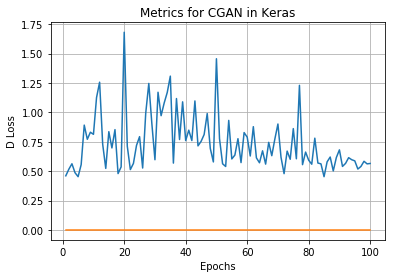

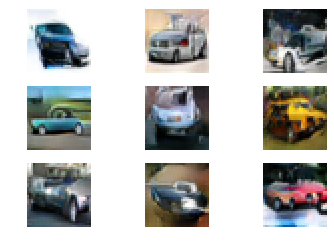

<Figure size 432x288 with 0 Axes>

In [13]:
num_epochs = 100
batch_size = 16
train(num_epochs, batch_size)

---
More information:


- Understanding of Convolutional Neural Network (CNN) http://bit.ly/2K6d1aH

- Developing a DCGAN Model in Tensorflow 2.0: http://bit.ly/2WyBQCJ

- DCGAN: http://bit.ly/2WulUBH